# Práctico 5 - Procesamiento Digital de Imágenes

In [1]:
import imageio.v2 as imageio
import numpy as np
from numpy.fft import fft,fft2,fftshift
from scipy import signal
from scipy.signal import convolve
import matplotlib.pyplot as plt
import copy
import time

In [2]:
#%% definición de funciones auxiliares
debug = 0
MAT_RGB2YIQ = np.array([[0.299, 0.587, 0.114],
                        [0.595716,-0.274453,-0.321263],
                        [0.211456,-0.522591, 0.311135]])

def apply_matrix(img, M):
    return np.matmul(img.reshape((-1,3)), M.T).reshape(img.shape)

def rgb2yiq(img):
    return apply_matrix(img, MAT_RGB2YIQ)

def yiq2rgb(img):
    return apply_matrix(img, np.linalg.inv(MAT_RGB2YIQ))

# -----------------------------------------------------------------------------
def conv2d(img,kernel):      
    rows, cols = img.shape
    N, _ = kernel.shape
    imgFilter = np.zeros(img.shape,dtype=img.dtype)
    guarda = round((N-1)/2)
    #t1 = time.perf_counter()
    for i in range(guarda,rows-guarda):
        for j in range(guarda,cols-guarda):
            val=0
            for x in range(N):
                for y in range(N):
                    val+=kernel[x,y]*img[i-guarda+x,j-guarda+y]
            imgFilter[i,j]=val
    return imgFilter

def kernel(name,N):

# ------------- pasa bajos -------------  
    if name == 'box':
        pulso=np.ones((1,N))
        box=pulso.T*pulso
        return box/box.sum()
    
    elif name == 'circle':
        circle=np.zeros((N,N));
        for i in range (N):
            x=i-(N-1)/2
            for j in range(N):
                y=j-(N-1)/2
                
                # image circle
                circle[i,j]=1 if (x**2+y**2)<=(N/2)**2  else 0        
        return circle/circle.sum()        
  
    elif name == 'bartlett':
        pulso=np.ones( (1,int((N+1)/2)) )
        pulso=signal.convolve(pulso, pulso)
        bart=pulso.T*pulso
        return bart/bart.sum()
    
    elif name=='gausiano':
        x=np.ones((1,2))
        for ord in range(3,N+1):
            xp=np.ones((1,x.size+1))
            for n in range(1,x.size):
                xp[0][n]=x[0][n-1]+x[0][n]
            x = xp
        gausiano=x.T*x    
        return gausiano/gausiano.sum()
    
# ------------- pasa altos -------------          
    elif name == 'laplaciano':
        if N==4:
            pa = np.array([[0,-1,0],[-1,4,-1],[0,-1,0]]);
            return pa/pa.max();

        elif N==8:
            pa = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
            return pa/pa.max();
        else:
            print('Para el filtro laplaciano el orden debe ser o 4 u 8')

    elif name == 'dog':
        ker1=(N^2)*kernel('gausiano',N)
        ker1=ker1/ker1.min();
        
        N=N-2;
        ker2=(N^2)*kernel('gausiano',N)
        ker2=ker2/ker2.min();
        K=int(ker1.sum()/ker2.sum())
        ker2=K*kernel_pads(ker2,1)
        dog=ker2-ker1;
        return dog
    
    else:
        print('error nombre kernel')

def kernel_pads(kernel,Npads):
    Nker = kernel.shape[0];
    kernel_pads = np.zeros((2*Npads+Nker,2*Npads+Nker));
    for i in range(Nker):
        for j in range(Nker):
            kernel_pads[i+Npads,j+Npads] = kernel[i,j];
    return kernel_pads

def kernel_pads_full(kernel,Npads):
    # devuelve kernel 1D, 2D con pads y fft
    Nker = kernel.shape[0];
    kernel_pads = np.zeros((2*Npads+Nker,2*Npads+Nker));
    for i in range(Nker):
        for j in range(Nker):
            kernel_pads[i+Npads,j+Npads] = kernel[i,j];
    ker2d = kernel_pads
    ker1d = ker2d[int((ker2d.shape[0]-1)/2),:];
    ker1d_fft = fftshift(np.abs(fft(ker1d)));
    ker2d_fft = fftshift(np.abs(fft2(ker2d)));
    w1d = np.linspace(-.5,.5,num=ker1d.shape[0])
    return (w1d,ker1d,ker1d_fft,ker2d,ker2d_fft)

 

# Filtros Pasabajos
Se implementan los kernels cuadrados
1. box 
2. circle 
3. bartlett 
4. gausiano

mediante la función **kernel(name_kernel,N)**, donde name_kernel puede ser {'box', 'circle', 'bartlett','gausiano'} y N es el orden (impar).


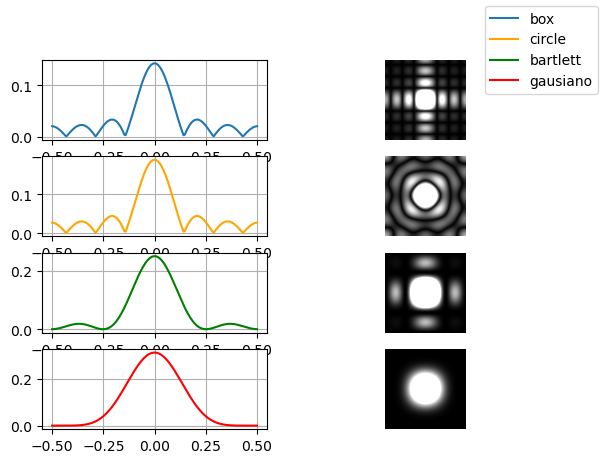

In [3]:
#%%
# -----------------------------------------------------------------------------    
# Seteo inicial
Npads = 75;
N = 7; # orden del kernel

#kernel a aplicar labels=['box', 'circle', 'bartlett','gausiano']
nameker1='box';
nameker2='circle';
nameker3='bartlett';
nameker4='gausiano';

#%% Visualización espectro filtros 2D todos los kernels
fig,(row1,row2,row3,row4) = plt.subplots(4,2);

ker=kernel(nameker1,N); lenker=ker.shape[0]
w1d,ker1d,ker1d_fft,ker2d,ker2d_fft = kernel_pads_full(ker,Npads)
row1[0].plot(w1d,ker1d_fft); row1[0].grid('both')
row1[1].imshow(5*ker2d_fft,cmap='gray',vmin=ker2d_fft.min(),vmax=ker2d_fft.max());  row1[1].axis('off')

ker=kernel(nameker2,N); lenker=ker.shape[0]
w1d,ker1d,ker1d_fft,ker2d,ker2d_fft = kernel_pads_full(ker,Npads)
row2[0].plot(w1d,ker1d_fft,'orange'); row2[0].grid('both')
row2[1].imshow(5*ker2d_fft,cmap='gray',vmin=ker2d_fft.min(),vmax=ker2d_fft.max()); row2[1].axis('off')

ker=kernel(nameker3,N); lenker=ker.shape[0]
w1d,ker1d,ker1d_fft,ker2d,ker2d_fft = kernel_pads_full(ker,Npads)
row3[0].plot(w1d,ker1d_fft,'green'); row3[0].grid('both')
row3[1].imshow(10*ker2d_fft,cmap='gray',vmin=ker2d_fft.min(),vmax=ker2d_fft.max()); row3[1].axis('off')

ker=kernel(nameker4,N); lenker=ker.shape[0]
w1d,ker1d,ker1d_fft,ker2d,ker2d_fft = kernel_pads_full(ker,Npads)
row4[0].plot(w1d,ker1d_fft,'red'); row4[0].grid('both')
row4[1].imshow(3*ker2d_fft,cmap='gray',vmin=ker2d_fft.min(),vmax=ker2d_fft.max()); row4[1].axis('off')
fig.legend([nameker1,nameker2,nameker3,nameker4])
#plt.legend([nameker1,nameker2,nameker3,nameker4])




Check normalizacion de kernels
sum:  box :  1.0 len;  7
sum:  circle :  1.0 len;  7
sum:  bartlett :  1.0 len;  7
sum:  gausiano :  1.0 len;  7


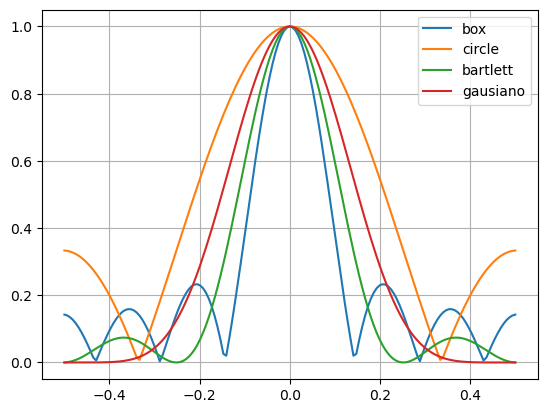

In [4]:
#%% Visualización espectro filtros 1D
_,ax1 = plt.subplots();
ker=kernel(nameker1,N)[0,:]; lenker=ker.size
pads = np.zeros((Npads),dtype=ker.dtype)
ker = np.concatenate((pads,ker,pads))/ker.sum()
kernel_fft = fftshift(np.abs(fft(ker)));

w = np.linspace(-.5,.5,num=ker.size)
ax1.plot(w,kernel_fft);
print('\nCheck normalizacion de kernels')
print('sum: ', nameker1, ': ', ker.sum(), 'len; ',lenker)

ker=kernel(nameker2,N)[0,:]; lenker=ker.size
ker = np.concatenate((pads,ker,pads))/ker.sum()
kernel_fft = fftshift(np.abs(fft(ker)));
ax1.plot(w,kernel_fft);
print('sum: ', nameker2, ': ', ker.sum(), 'len; ',lenker)

ker=kernel(nameker3,N)[0,:]; lenker=ker.size
ker = np.concatenate((pads,ker,pads))/ker.sum()
kernel_fft = fftshift(np.abs(fft(ker)));
ax1.plot(w,kernel_fft);
print('sum: ', nameker3, ': ', ker.sum(), 'len; ',lenker)

ker=kernel(nameker4,N)[0,:]; lenker=ker.size
ker = np.concatenate((pads,ker,pads))/ker.sum()
kernel_fft = fftshift(np.abs(fft(ker)));
ax1.plot(w,kernel_fft);
print('sum: ', nameker4, ': ', ker.sum(), 'len; ',lenker)

plt.legend([nameker1,nameker2,nameker3,nameker4])
plt.grid('both')



Procesando con kernel box de tamaño  7

Tiempo para el filtrado(conv2):  10.23 [seg]


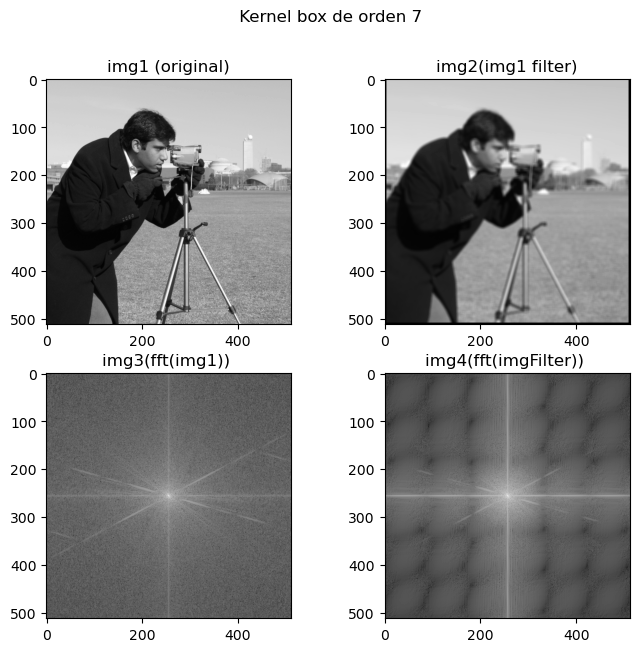

In [5]:
#%% Filtrado con kernel pb
nameker = 'box' # labels=['box', 'circle', 'bartlett','gausiano']
fig3, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,7))

# Carga de imagen a procesar
imgin = imageio.imread('imageio:camera.png')/255
imgL = imgin if imgin.ndim==2 else rgb2yiq(imgin)[:,:,0];
fft_imgL = np.abs(fft2(imgL));
img1 = imgL;
img3 = fft_imgL;
# ------------- plots -------------
ax1.imshow(img1, 'gray'); ax1.title.set_text('img1 (original)')
ax3.imshow(fftshift(np.log(img3)),cmap='gray'); ax3.title.set_text('img3(fft(img1)) ')

# ------------------------------- img filtrada--------------------------------------- 
print('\nProcesando con kernel', nameker, 'de tamaño ', N )
ker=kernel(nameker,N)
t1 = time.perf_counter()
imgFilter=conv2d(imgL,ker)
t2 = time.perf_counter()

fft_imgFilter = np.abs(fft2(imgFilter));
print('\nTiempo para el filtrado(conv2): ',1*round(t2-t1,2),'[seg]')
img2=imgFilter;
img4=fft_imgFilter;

# ------------- plots -------------
ax2.imshow(1*((img2)), cmap='gray'); ax2.title.set_text('img2(img1 filter)')
ax4.imshow(1*fftshift(np.log(img4)),cmap='gray',);ax4.title.set_text('img4(fft(imgFilter)) ') #,vmin=img4.min(),vmax=img4.max())
fig3.suptitle(' Kernel '+nameker+' de orden '+str(N)); 

# Filtros Pasaaltos
1. Laplace (4 y 8 vecinos) 
2. Pasaaltos (a partir de un pasabajos)

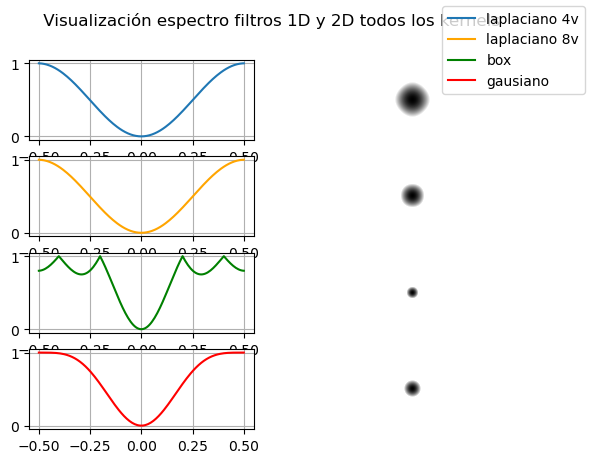

In [6]:
def clampeoL(img):
    img[img>=1] = 1;
    img[img<=0] = 0;
    return img

def kernel_pads_full(name,N,Npads):
    # devuelve kernel 1D, 2D con pads y fft
    ker=kernel(name,N);
    N = ker.shape[0];
    kernel_pads = np.zeros((2*Npads+N,2*Npads+N));
    for i in range(N):
        for j in range(N):
            kernel_pads[i+Npads,j+Npads] = ker[i,j];
    ker2d = kernel_pads
    ker1d = ker2d[int((ker2d.shape[0]-1)/2)];
    ker2d_fft = fftshift(np.abs(fft2(ker2d))); ker2d_fft = ker2d_fft/ker2d_fft.max()
    ker1d_fft = ker2d_fft[int((ker2d.shape[0]-1)/2)]; ker1d_fft = ker1d_fft/ker1d_fft.max()
    w1d = np.linspace(-.5,.5,num=ker1d.shape[0])
    return (w1d,ker1d,ker1d_fft,ker2d,ker2d_fft)
# -----------------------------------------------------------------------------    
# Seteo inicial
Npads = 75;
N = 5; # orden del kernel

#kernel a aplicar labels=['box', 'circle', 'bartlett','gausiano';
nameker1='laplaciano 4v';
nameker2='laplaciano 8v';
nameker3='box';
nameker4='gausiano';

# Visualización espectro filtros 2D todos los kernels
fig1,(row1,row2,row3,row4) = plt.subplots(4,2);

w1d_1,ker1d_1,ker1d_fft_1,ker2d_1,ker2d_fft_1 = kernel_pads_full('laplaciano',4,Npads)
row1[0].plot(w1d_1,ker1d_fft_1); row1[0].grid('both')
row1[1].imshow(5*ker2d_fft_1,cmap='gray',vmin=ker2d_fft_1.min(),vmax=ker2d_fft_1.max());  row1[1].axis('off')

w1d_2,ker1d_2,ker1d_fft_2,ker2d_2,ker2d_fft_2 = kernel_pads_full('laplaciano',8,Npads)
row2[0].plot(w1d_2,ker1d_fft_2,'orange'); row2[0].grid('both')
row2[1].imshow(5*ker2d_fft_2,cmap='gray',vmin=ker2d_fft_2.min(),vmax=ker2d_fft_2.max()); row2[1].axis('off')

w1d_3,ker1d_3,ker1d_fft_3,ker2d_3,ker2d_fft_3 = kernel_pads_full(nameker3,N,Npads)
row3[0].plot(w1d_3,1-ker1d_fft_3,'green'); row3[0].grid('both')
row3[1].imshow(5*(1-ker2d_fft_3),cmap='gray',vmin=ker2d_fft_3.min(),vmax=ker2d_fft_3.max()); row3[1].axis('off')

w1d_4,ker1d_4,ker1d_fft_4,ker2d_4,ker2d_fft_4 = kernel_pads_full(nameker4,N,Npads)
row4[0].plot(w1d_4,1-ker1d_fft_4,'red'); row4[0].grid('both')
row4[1].imshow(5*(1-ker2d_fft_4),cmap='gray',vmin=ker2d_fft_4.min(),vmax=ker2d_fft_4.max()); row4[1].axis('off')

fig1.legend([nameker1,nameker2,nameker3,nameker4])
fig1.suptitle(' Visualización espectro filtros 1D y 2D todos los kernels'); 



sum  laplaciano 4v :  0.5 orden;  3
sum  laplaciano 8v :  0.75 orden;  3
sum  box :  0.2 orden;  5
sum  gausiano :  0.375 orden;  5


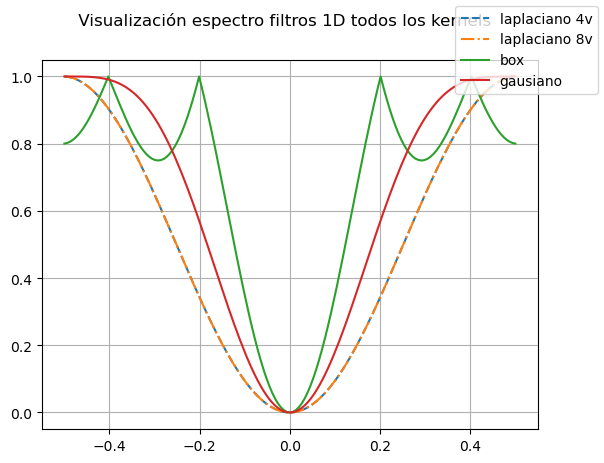

In [7]:
#%% Visualización espectro filtros 1D
fig2,ax = plt.subplots();
ax.plot(w1d_1,ker1d_fft_1,'--')
ax.plot(w1d_2,ker1d_fft_2,'-.');
ax.plot(w1d_3,1-ker1d_fft_3);
ax.plot(w1d_4,1-ker1d_fft_4);
ax.grid('both')

print('sum ', nameker1, ': ', ker1d_1.sum(), 'orden; ',ker1d_1.shape[0]-2*Npads)
print('sum ', nameker2, ': ', ker1d_2.sum(), 'orden; ',ker1d_2.shape[0]-2*Npads)
print('sum ', nameker3, ': ', ker1d_3.sum(), 'orden; ',ker1d_3.shape[0]-2*Npads)
print('sum ', nameker4, ': ', ker1d_4.sum(), 'orden; ',ker1d_4.shape[0]-2*Npads)
fig2.legend([nameker1,nameker2,nameker3,nameker4])
fig2.suptitle(' Visualización espectro filtros 1D todos los kernels'); 



Procesando con kernel laplaciano 4v

Tiempo para el filtrado pasa-alto(conv2):  3.53 [seg]


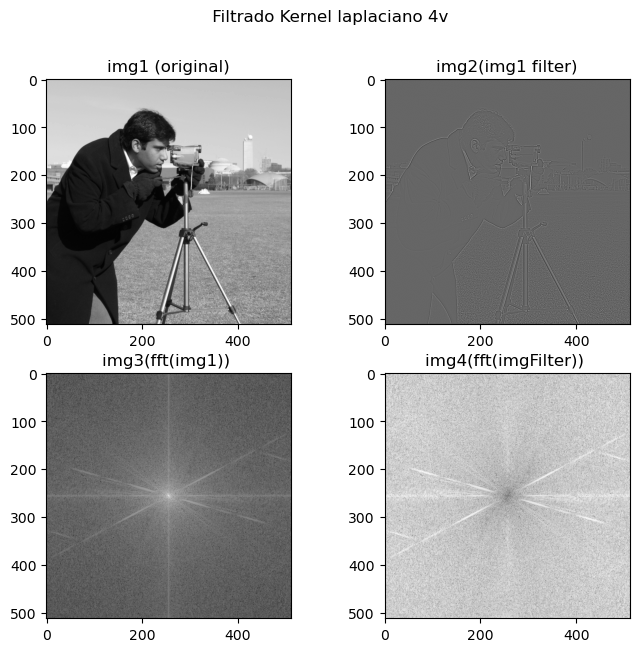

In [8]:
#%% Filtrado con kernel pasa-alto
nameker = nameker1
N=7

# Carga de imagen a procesar
imgin = imageio.imread('imageio:camera.png')/255
imgL = imgin if imgin.ndim==2 else rgb2yiq(imgin)[:,:,0];
fft_imgL = np.abs(fft2(imgL));

print('\nProcesando con kernel', nameker)
ker=kernel('laplaciano',4)
t1 = time.perf_counter()
imgFilter=conv2d(imgL,ker)
t2 = time.perf_counter()
print('\nTiempo para el filtrado pasa-alto(conv2): ',1*round(t2-t1,2),'[seg]')

# --------- img filtrada ----------
fft_imgFilter = np.abs(fft2(imgFilter));
img2=imgFilter;
img4=fft_imgFilter;

# ------------- plots -------------
fig3, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,7))

img1 = imgL;
img3 = fft_imgL;
ax1.imshow(img1, 'gray'); ax1.title.set_text('img1 (original)')
ax3.imshow(fftshift(np.log(img3)),cmap='gray'); ax3.title.set_text('img3(fft(img1)) ')

ax2.imshow(1*((img2)), cmap='gray'); ax2.title.set_text('img2(img1 filter)')
ax4.imshow(1*fftshift(np.log(img4)),cmap='gray',);ax4.title.set_text('img4(fft(imgFilter)) ') #,vmin=img4.min(),vmax=img4.max())
fig3.suptitle(' Filtrado Kernel '+nameker); 

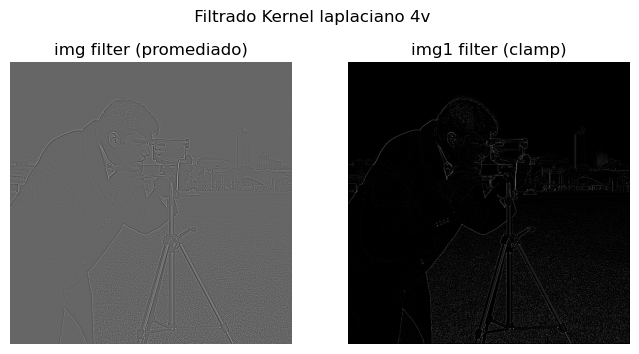

In [9]:
#%%
fig4,ax4=plt.subplots(1,2,figsize=(8,4));
ax4[0].imshow(1*((img2)), cmap='gray'); ax4[0].title.set_text('img filter (promediado)')
ax4[0].axis('off')
## Me parece que esto(abajo) es equivalente al promediado.... el hecho de transformar la componente L al intervalo [0,1]
img2_norm = (1/(img2.max()-img2.min()))*(img2-img2.min());

img2_clamp = clampeoL(copy.deepcopy(img2));
ax4[1].imshow(1*((img2_clamp)), cmap='gray'); ax4[1].title.set_text('img1 filter (clamp)')
ax4[1].axis('off')
fig4.suptitle(' Filtrado Kernel '+nameker); 

# Filtros Pasabanda

Difference of Gaussian (DoG)


Tiempo para el filtrado DoG (conv2):  7.86 [seg]


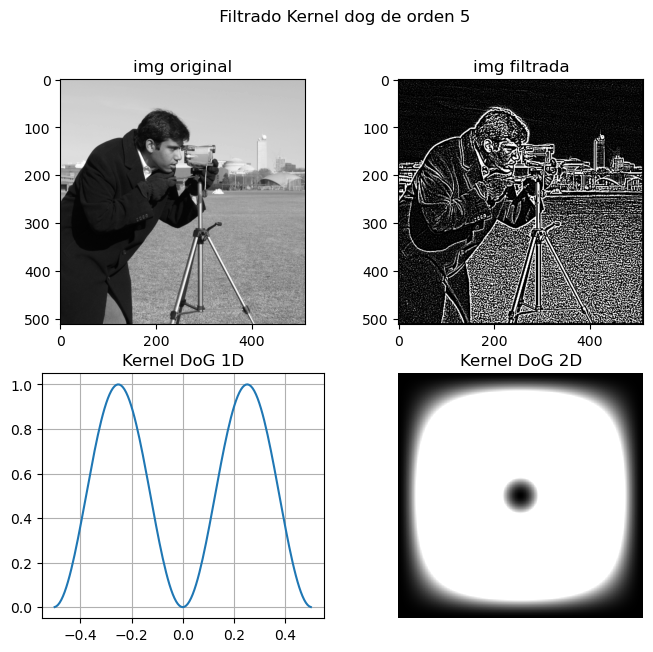

In [10]:
#%% Filtrado con kernel DoG
N=5;
nameker='dog';
dog2d= kernel(nameker,N);

t1 = time.perf_counter()
imgFilter=conv2d(imgL,dog2d)
t2 = time.perf_counter()
print('\nTiempo para el filtrado DoG (conv2): ',1*round(t2-t1,2),'[seg]')

# Visualización espectro filtros 2D todos los kernels
dog2d = kernel_pads(dog2d,Npads);
ker2d = copy.deepcopy(dog2d);
ker1d = ker2d[int((ker2d.shape[0]-1)/2)];

ker2d_fft = fftshift(np.abs(fft2(ker2d))); ker2d_fft = ker2d_fft/ker2d_fft.max()
ker1d_fft = ker2d_fft[int((ker2d.shape[0]-1)/2)]; ker1d_fft = ker1d_fft/ker1d_fft.max()
w1d = np.linspace(-.5,.5,num=ker1d.shape[0])

# Visualización espectro filtros 2D todos los kernels
fig5,ax5 = plt.subplots(2,2,figsize=(8,7));
ax5[0][0].imshow(imgL, 'gray'); ax5[0][0].title.set_text('img original')
ax5[0][1].imshow(1*((clampeoL(imgFilter))), cmap='gray'); ax5[0][1].title.set_text('img filtrada')

ax5[1][0].plot(w1d,ker1d_fft); ax5[1][0].grid('both'); ax5[1][0].title.set_text('Kernel DoG 1D')
ax5[1][1].imshow(5*ker2d_fft,cmap='gray',vmin=ker2d_fft.min(),vmax=ker2d_fft.max());  ax5[1][1].axis('off');
ax5[1][1].title.set_text('Kernel DoG 2D')
fig5.suptitle(' Filtrado Kernel '+nameker+' de orden '+str(N)); 
